# 1. Import relevant modules

In [21]:
import sys
sys.path.append('../python') #Path to load WI_Solver_Utils.py
import WI_Solver_utils
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import trange
from WI_Solver_utils import InflatonModel, Background, Perturbations, Growth_factor
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

In [2]:
####################################################################
#   Define tau array over which we solved for the perturbations:   #
####################################################################
"""Recall: \tau=\ln(z)=\ln(k/(aH))"""

tau_ini = 6
tau_end = -1
N = 100000
dtau = (tau_end - tau_ini) / N # DT is a negative quantity as expected since tau is decreasing over time
taus = np.linspace(tau_ini, tau_end, N)


#################################
#   Define Global Parameters:   #
#################################

Mpl = 1 # Everything is in Plank units M_{pl}
g = 228.27  # SUSY relativistic degrees of freedom
a1 = np.pi**2/30*g

Neinflation= 60 #Number of e-folds of inflation
Nruns=700 #How many runs did we average over to compute the perturbations


In [3]:
#######################################################################
#   Define the type of inflaton potential and its main parammeters:   #
#######################################################################

potential_type='minimal'

M_sigma = 10**(6)/(2.42*10**(18))  # mass of waterfall field in units of Mpl
m_phi = 10**(-2)/(2.42*10**(18))  # mass of inflaton in units of Mpl
lv = 10**(-2)

Model = InflatonModel(potential_type, [M_sigma, m_phi, lv], g, a1, Mpl)

################################################
#   Initial conditions on \phi0 and Q array:   #
################################################

"""
Note here we load previously computed initial conditions that guarantee N_e= Neinflation + 8 efolds of inflation.
To see how these were computed, check out the notebook "ICs_ph0.ipynb"
"""

ICs_Q0_ph0=np.loadtxt('../ICS_ph0-Q0s/ICS_ph0-Q0s_'+potential_type+'.txt') 
Q0s=ICs_Q0_ph0[:,0]
ph0s=ICs_Q0_ph0[:,1]

########################################################################
#   Compute the Analytic approximation of the Power spectrum for c=0   #
########################################################################

R2_analytic=np.zeros(len(Q0s))
for i in trange(len(Q0s)):
    Bg=Background(Model,ph0s[i],Q0s[i])
    R2_analytic[i]=Bg.analytic_power_spectrum(71, 10**(6), taus, Neinflation)
    del Bg


100%|███████████████████████████████████████████| 52/52 [00:31<00:00,  1.63it/s]


In [4]:
##########################################################################################
#   Load the files containing the numerically derived values of the Power spectrum for   #
#   different combinations of c and m..                                                  #
##########################################################################################

_,R2m_c3m0,R2std_c3m0=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(potential_type)+'_c3m0_n'+str(int(N))+'_Nr'+str(Nruns)+'.txt')
_,R2m_c1m0,R2std_c1m0=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(potential_type)+'_c1m0_n'+str(int(N))+'_Nr'+str(Nruns)+'.txt')
_,R2m_cn1m0,R2std_cn1m0=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(potential_type)+'_c-1m0_n'+str(int(N))+'_Nr'+str(Nruns)+'.txt')


In [5]:
########################
#   Case 1: c=3, m=0   #
########################

Gfc3m0=Growth_factor(Model,Q0s,ph0s,R2m_c3m0,R2std_c3m0,Nruns,71,10**(6),taus,Neinflation,3,0)

pars_c3m0_complex,_,GQ_sigc3m0,GQ_errc3m0=Gfc3m0.growth_factor_fit(method='complex',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic)

pars_c3m0_simple,_=Gfc3m0.growth_factor_fit(method='simple',output_data=False,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic)


########################
#   Case 2: c=1, m=0   #
########################

Gfc1m0=Growth_factor(Model,Q0s,ph0s,R2m_c1m0,R2std_c1m0,Nruns,71,10**(6),taus,Neinflation,1,0)

pars_c1m0_complex,_,GQ_sigc1m0,GQ_errc1m0=Gfc1m0.growth_factor_fit(method='complex',output_data=True,analytic_power_spectrum=True,deltaR2_analytic=R2_analytic)

pars_c1m0_simple,_=Gfc1m0.growth_factor_fit(method='simple',output_data=False,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic)

#########################
#   Case 3: c=-1, m=0   #
#########################

Gfcn1m0=Growth_factor(Model,Q0s,ph0s,R2m_cn1m0,R2std_cn1m0,Nruns,71,10**(6),taus,Neinflation,-1,0)

pars_cn1m0_simple,_,GQ_sigcn1m0,GQ_errcn1m0=Gfcn1m0.growth_factor_fit(output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic)


[5.26590466e+00 9.96301546e+00 3.45212531e+00 8.66101151e+00
 9.58156939e+00 6.73104586e+00 9.91126899e-01 1.35365965e+01
 2.07363315e+00 1.74007147e-02 1.48811222e+01 9.17452306e-18]


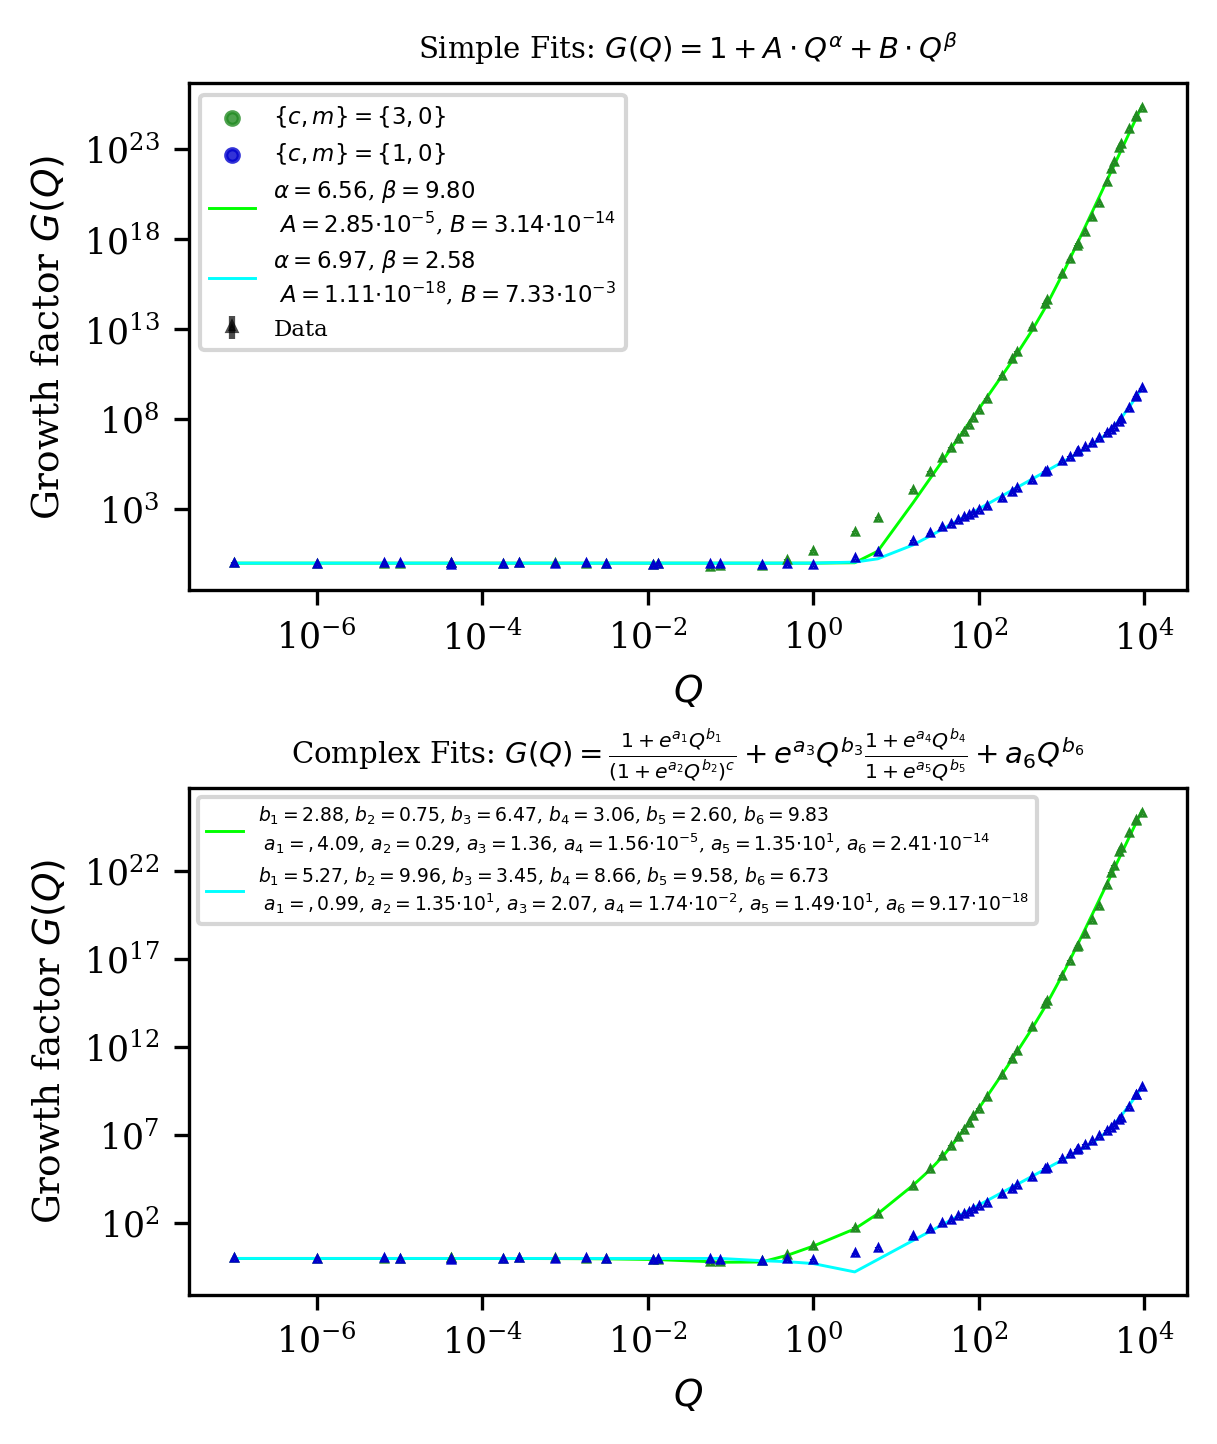

In [44]:
def format_fit_pars(pars, mode='complex'):
    global formatted_pars
    if mode=='complex':
        formatted_pars=[r'$b_1=',r'$b_2=',r'$b_3=',r'$b_4=',r'$b_5=',r'$b_6=',r'$a_1=,',r'$a_2=',r'$a_3=',r'$a_4=',r'$a_5=',r'$a_6=']
    if mode=='simple':
        formatted_pars=[r'$\alpha=',r'$\beta=',r'$A=',r'$B=']
    for i in range(len(pars)):
        pv=pars[i]
        exp = math.floor(math.log10(abs(pv))) # automatically detect the value of c
        if (exp>=1) or (exp<=-2):
            formatted_pv = "{:.2f}⋅10^{{{}}}".format(pv / 10**exp, exp)
        else:
            formatted_pv = "{:.2f}".format(pv)
        #Add formatted_pv to the ith element of formatted_pars, before the last $ sign:
        formatted_pars[i]=formatted_pars[i]+formatted_pv+'$'
    #Return as a single string of two columns with commas between the elements:
    return ', '.join(formatted_pars[:len(pars)//2])+'\n '+', '.join(formatted_pars[len(pars)//2:])


#Make Figure where I plot the data and the fit:
fig1=plt.figure(figsize=(4.5,5.8),dpi=300)
gs1 = GridSpec(42,44,figure=fig1)
ax1 = fig1.add_subplot(gs1[2:18,1:-1])
ax2 = fig1.add_subplot(gs1[24:40,1:-1])

##############################
# Useful for general legend: #
##############################
ax1.scatter(np.NaN, np.NaN,ls='None',marker='.',color='forestgreen',alpha=0.8, label='$\{c,m\}=\{3,0\}$')
ax1.scatter(np.NaN, np.NaN,ls='None',marker='.',color='mediumblue',alpha=0.8, label='$\{c,m\}=\{1,0\}$')
ax1.errorbar(np.NaN, np.NaN, yerr=np.NaN,c='k', label=r'Data', marker='^',ls='none',markersize=2,alpha=0.7)

ax1.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_ylabel("Growth factor $G(Q)$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_title(r"Simple Fits: $G(Q)=1+A \cdot Q^{\alpha}+B\cdot Q^{\beta}$",fontdict={'fontsize':7,'family':'serif'})
ax1.errorbar(Q0s,GQ_sigc3m0,yerr=GQ_errc3m0,c='forestgreen',marker='^',ls='none',markersize=1)
ax1.errorbar(Q0s,GQ_sigc1m0,yerr=GQ_errc1m0,c='mediumblue',marker='^',ls='none',markersize=1)
ax1.plot(Q0s,Gfc3m0.growth_factor_fit_func_positive_c_simple(Q0s,*pars_c3m0_simple),c='lime',label=format_fit_pars(pars_c3m0_simple,'simple'),linewidth=0.7)
ax1.plot(Q0s,Gfc1m0.growth_factor_fit_func_positive_c_simple(Q0s,*pars_c1m0_simple),c='cyan',label=format_fit_pars(pars_c1m0_simple,'simple'),linewidth=0.7)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(prop={'family':'serif','size':5.5},framealpha=0.8)

ax2.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax2.set_ylabel("Growth factor $G(Q)$",fontdict={'fontsize':9,'family':'serif'})
ax2.set_title(r"Complex Fits: $G(Q)=\frac{1+e^{a_1}Q^{b_1}}{(1+e^{a_2}Q^{b_2})^{c}}+e^{a_3}Q^{b_3}\frac{1+e^{a_4}Q^{b_4}}{1+e^{a_5}Q^{b_5}}+a_6 Q^{b_6}$",fontdict={'fontsize':7,'family':'serif'})
ax2.errorbar(Q0s,GQ_sigc3m0,yerr=GQ_errc3m0,c='forestgreen',marker='^',ls='none',markersize=1)
ax2.errorbar(Q0s,GQ_sigc1m0,yerr=GQ_errc1m0,c='mediumblue',marker='^',ls='none',markersize=1)
ax2.plot(Q0s,Gfc3m0.growth_factor_fit_func_positive_c_complex(Q0s,*pars_c3m0_complex),c='lime',label=format_fit_pars(pars_c3m0_complex),linewidth=0.7)
ax2.plot(Q0s,Gfc1m0.growth_factor_fit_func_positive_c_complex(Q0s,*pars_c1m0_complex),c='cyan',label=format_fit_pars(pars_c1m0_complex),linewidth=0.7)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend(prop={'family':'serif','size':4.5},framealpha=0.8)


plt.show()
plt.close()
